In [1]:
import secml.data
import torch
from torchvision import transforms

from utils import download_gdrive
from secml.array import CArray
from secml.ml import CClassifierPyTorch, CNormalizerMeanStd
from models.models import SparseResNet18
import os
import torch.utils.data
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from secml.adv.attacks import CFoolboxPGDLinf


# Load data and model

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1)


def load_model():
    MODEL_ID = '1Af_owmMvg1LxjITLE1gFUmPx5idogeTP'  # google drive id
    gamma = 0.1
    filepath = f'kwta_spresnet18_{gamma}_cifar_adv.pth'
    if not os.path.exists(filepath):
        download_gdrive(MODEL_ID, filepath)
    model = SparseResNet18(sparsities=[gamma, gamma, gamma, gamma], sparse_func='vol')
    state_dict = torch.load(filepath, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    model.to(device)
    return model


def load_data(data_dir, dataset_name, shuffle=True,
              train=True, transform=None, num_samples=None):
    tr = [transforms.ToTensor()]
    if transform is not None:
        tr = [transforms.ToTensor(), transforms.Lambda(transform)]
    transform = transforms.Compose(tr)

    if dataset_name == 'CIFAR10':
        dataset = datasets.CIFAR10(data_dir, train=train, transform=transform, download=True)
    elif dataset_name == 'MNIST':
        dataset = datasets.MNIST(data_dir, train=train, transform=transform, download=True)
    else:
        raise ValueError(f"Dataset {dataset_name} not available.")

    if shuffle is True:
        indexes = torch.randperm(len(dataset))
    else:
        indexes = torch.arange(0, len(dataset))

    if num_samples is not None:
        indexes = indexes[:min(len(dataset), num_samples)]
    dataset = torch.utils.data.Subset(dataset, indexes)
    loader = torch.utils.data.DataLoader(dataset, batch_size=N_SAMPLES)
    x, y = next(iter(loader))
    x, y = x.to(device), y.to(device)
    return x, y


abs_step_size = 0.01
random_start = False
steps = 50
epsilons = np.linspace(0.0, 16 / 255, num=10)
epsilon = 8/255 # this is used for computing the indicators
model = load_model()
# get samples from the dataset
N_SAMPLES = 100
images, labels = load_data('data', 'CIFAR10', num_samples=N_SAMPLES)

Files already downloaded and verified


# Secml Evaluation

In [3]:
def security_evaluation(model, dataset, attack, param_name, param_values):
    preds = model.predict(dataset.X)
    misclassified = preds != dataset.Y
    results = []
    for param_value in param_values:
        attack.set(param_name, param_value)
        samples_to_test_idx = np.where(misclassified.logical_not().tondarray())[0]
        samples_to_test = dataset[samples_to_test_idx.tolist(), :]
        y_pred_adv, scores, adv_ds, fobj = attack.run(samples_to_test.X, samples_to_test.Y)
        now_misclassified = y_pred_adv != adv_ds.Y
        now_misclassified = samples_to_test_idx[now_misclassified.ravel().tolist()]
        misclassified[now_misclassified.tolist()] = True
        results += [(dataset.X.shape[0] - misclassified.sum())]
    results = [r / dataset.X.shape[0] for r in results]
    return results


In [4]:
normalizer = CNormalizerMeanStd(mean=(0, 0, 0), std=(1, 1, 1))
clf = CClassifierPyTorch(model, input_shape=(3, 32, 32), pretrained=True,
                         pretrained_classes=CArray(list(range(10))), preprocess=normalizer)

secml_attack = CFoolboxPGDLinf(clf, abs_stepsize=abs_step_size, steps=steps,
                               random_start=random_start, epsilons=epsilon)

test_set = secml.data.CDataset(CArray(images.view(N_SAMPLES, -1).cpu()), CArray(labels.cpu()))
y_pred, _, adv_ds, _ = secml_attack.run(test_set.X, test_set.Y)
success = y_pred != adv_ds.Y

clf = CClassifierPyTorch(model, input_shape=(3, 32, 32), pretrained=True,
                         pretrained_classes=CArray(list(range(10))), preprocess=None)

secml_attack = CFoolboxPGDLinf(clf, abs_stepsize=0.01, steps=40,
                               random_start=False)  # same params as the foolbox defaults


test_set = secml.data.CDataset(CArray(images.view(N_SAMPLES, -1).cpu()), CArray(labels.cpu()))

In [5]:
pgd_sec_eval = security_evaluation(clf, test_set, secml_attack, 'epsilon', epsilons)

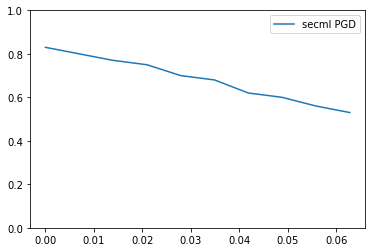

In [6]:
plt.figure()
plt.plot(epsilons, pgd_sec_eval, label='secml PGD')

plt.ylim([0, 1])

plt.legend()

In [7]:
import copy
from indicators.indicators import compute_indicators

all_indicators = []

for sample in range(N_SAMPLES):
    x, y = test_set.X[sample, :], test_set.Y[sample]
    pred = clf.predict(x)

    indicators = compute_indicators(copy.deepcopy(secml_attack), x, y, clf)
    all_indicators.append(indicators)

all_indicators_orig_eval = pd.concat(all_indicators, axis=0, ignore_index=True)

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None):
    print("\n\nAverage Indicators")
    print(all_indicators_orig_eval.mean())



Average Indicators
Attack Success       0.350000
Silent Success       0.250000
Break-point Angle    0.400113
Increasing Loss      0.676019
Zero Gradients       0.000000
dtype: float64


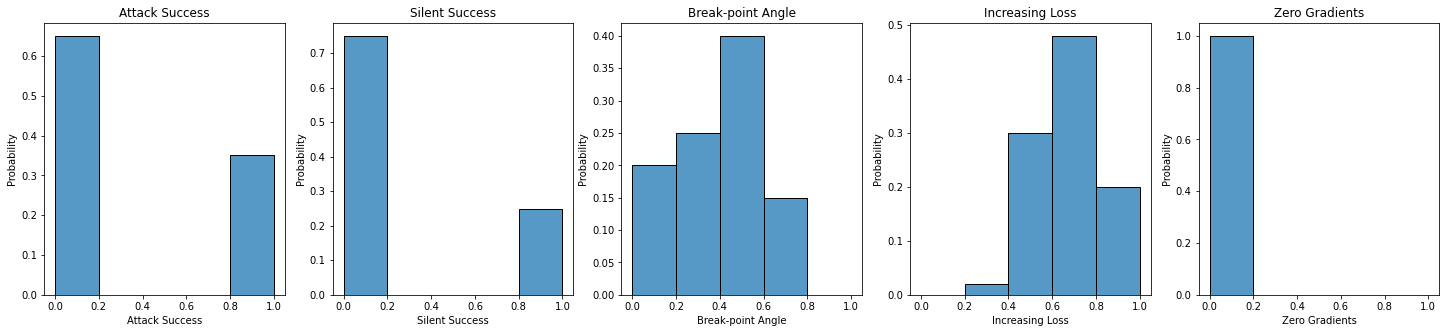

In [8]:
import seaborn as sns
n_cols = len(all_indicators_orig_eval.columns)
fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(25, 5))
for i, column in enumerate(all_indicators_orig_eval):
    sns.histplot(all_indicators_orig_eval[column], ax=axes[i], bins=5, binrange=[0, 1], stat='probability').set_title(column)


# First, let's fix the implementation

In [9]:
from attacks.pgd_best_point import CFoolboxPGDBest

patched_pgd = CFoolboxPGDBest(clf, abs_stepsize=0.01, steps=40,
                               random_start=False, epsilons=8/255)

sec_eval_patched = security_evaluation(clf, test_set, patched_pgd, 'epsilon', epsilons)

test_set = secml.data.CDataset(CArray(images.view(N_SAMPLES, -1).cpu()), CArray(labels.cpu()))


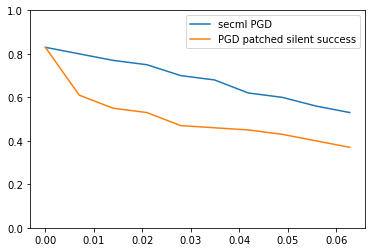

In [10]:
plt.figure()
plt.plot(epsilons, pgd_sec_eval, label='secml PGD')
plt.plot(epsilons, sec_eval_patched, label='PGD patched silent success')
plt.ylim([0, 1])

plt.legend()

# Then, we can fix the noisy descent problem (detected with increasing loss + bad init)

In [11]:
from attacks.pgd_noisy_descent import CFoolboxAveragedPGD

k = 50 # number of neighbors for smoothing
patched_and_smoothed_pgd = CFoolboxAveragedPGD(clf, abs_stepsize=0.01, steps=40,
                               random_start=False, epsilons=8/255, k=k)

sec_eval_patched_2 = security_evaluation(clf, test_set, patched_and_smoothed_pgd, 'epsilon', epsilons)

test_set = secml.data.CDataset(CArray(images.view(N_SAMPLES, -1).cpu()), CArray(labels.cpu()))


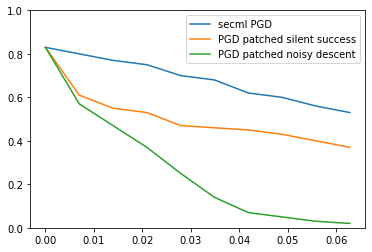

In [14]:

plt.figure()
plt.plot(epsilons, pgd_sec_eval, label='secml PGD')
plt.plot(epsilons, sec_eval_patched, label='PGD patched silent success')
plt.plot(epsilons, sec_eval_patched_2, label='PGD patched noisy descent')
plt.ylim([0, 1])

plt.legend()


In [13]:
all_res = {
    'pgd_secml': (epsilons.tolist(), pgd_sec_eval,),
    'silent_success': (epsilons.tolist(), sec_eval_patched,),
    'smoothing': (epsilons.tolist(), sec_eval_patched_2,),
}

import json
with open("results.json", 'w') as f:
    json.dump(all_res, f, indent=4)